In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud
import sqlite3
import cpca
%matplotlib inline

In [2]:
dx_con = sqlite3.connect('dxadv.db')
doctors = pd.read_sql_query('select * from doctors;', dx_con)
doctors.head()

,id,real_id,name,gender,location,section_group,section_group_id,hospital,title
0,51845,1117,徐宏俊,1,北京西城区,皮肤科,9,首都医科大学附属北京友谊医院,主治医师
1,3953365,5479,张英,0,九江市,皮肤性病科,9,九江学院附属医院东院,副主任医师
2,2170258,6661,吴晓霞,0,咸阳市秦都区,皮肤科,9,陕西中医药大学附属医院,主任医师
3,11343870,8103,周真,0,广州市番禺区,皮肤性病科,9,广东省妇幼保健院番禺院区,主治医师
4,119604,7762,吴剑,1,沈阳市和平区,皮肤性病科,9,中国医科大学附属第一医院,主治医师


In [3]:
doctors['section_group_id'] = doctors['section_group_id'].astype('category')
doctors['gender'] = doctors['gender'].astype('category')

In [4]:
doctors['title'].unique()

array(['主治医师', '副主任医师', '主任医师', '医师'], dtype=object)

In [5]:
doctors['title'] = doctors['title'].astype('category')
doctors['title_level'] = doctors['title'].map({
    '主治医师': 1,
    '副主任医师':2,
    '主任医师':3,
    '医师':0,
}).astype('category')

In [6]:
doctors = doctors.rename(columns={'section_group':'section'})
section_id_map = {
    9: '皮肤性病科',
    2: '儿科',
    5: '妇产科',
    8: '泌尿外科',
    40: '骨科',
    3: '内分泌科',
    60: '心血管内科',
    12: '神经内科',
    64: '消化内科',
    57: '肾脏内科',
    18: '美容整形科',
    98: '药剂科',
    6: '普通内科',
    58: '眼科',
    11: '精神心理科',
    10: '肿瘤科',
    4: '耳鼻咽喉科',
    73: '风湿免疫科',
    71: '全科',
    56: '口腔科',
    55: '呼吸内科',
    7: '普外科',
    66: '心胸外科',
    63: '神经外科',
    65: '肝胆胰腺外科',
    76: '甲状腺乳腺外科',
    70: '血液科',
    394: '影像检验科',
    68: '感染科 传染科',
    79: '疼痛科 麻醉科',    
}
doctors['section_group'] = doctors['section_group_id'].map(section_id_map).astype('category')

In [7]:
split_location = cpca.transform(doctors['location'], cut=False, lookahead=12)
split_location.columns = ['province', 'city', 'district', 'address']
doctors = doctors.join(split_location[['province', 'city', 'district']])

In [8]:
doctors.head()

,id,real_id,name,gender,location,section,section_group_id,hospital,title,title_level,section_group,province,city,district
0,51845,1117,徐宏俊,1,北京西城区,皮肤科,9,首都医科大学附属北京友谊医院,主治医师,1,皮肤性病科,北京市,北京市,西城区
1,3953365,5479,张英,0,九江市,皮肤性病科,9,九江学院附属医院东院,副主任医师,2,皮肤性病科,江西省,九江市,
2,2170258,6661,吴晓霞,0,咸阳市秦都区,皮肤科,9,陕西中医药大学附属医院,主任医师,3,皮肤性病科,陕西省,咸阳市,秦都区
3,11343870,8103,周真,0,广州市番禺区,皮肤性病科,9,广东省妇幼保健院番禺院区,主治医师,1,皮肤性病科,广东省,广州市,番禺区
4,119604,7762,吴剑,1,沈阳市和平区,皮肤性病科,9,中国医科大学附属第一医院,主治医师,1,皮肤性病科,辽宁省,沈阳市,和平区


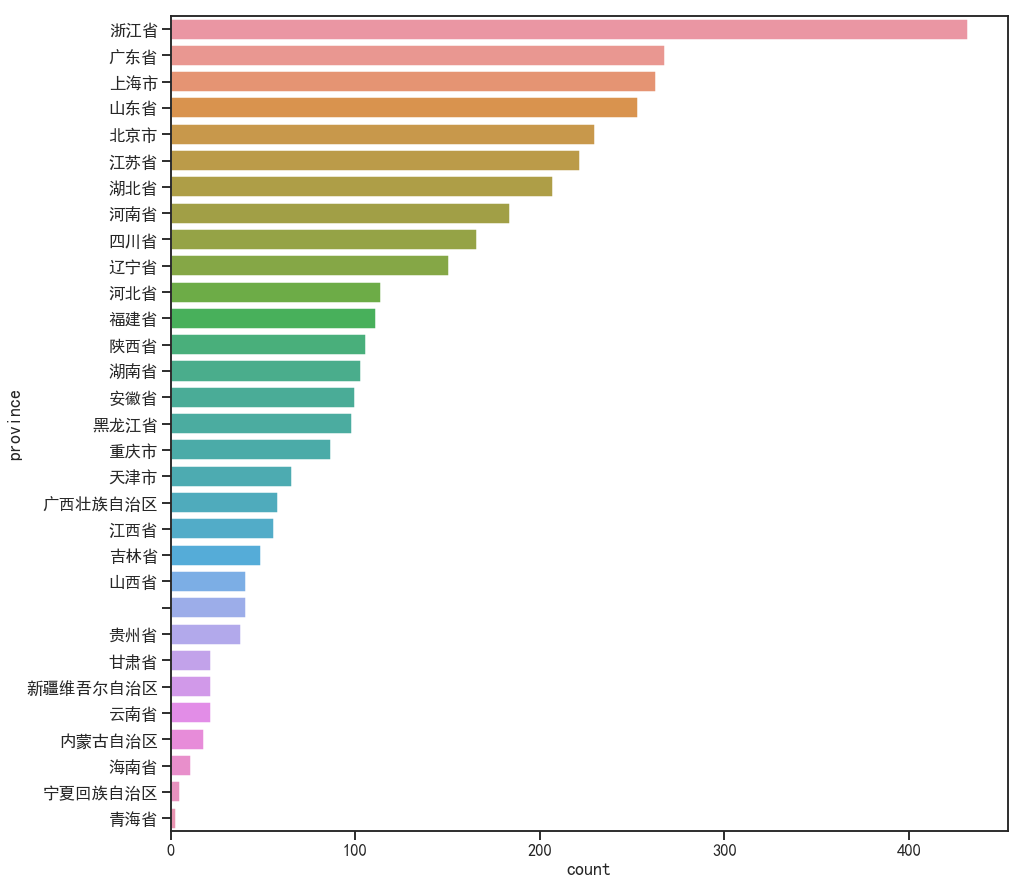

In [9]:
fig = plt.figure(figsize=(15, 15))
sns.set_style('ticks')
sns.set_context('talk')
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
ax = sns.countplot(y = 'province', data=doctors, order = doctors['province'].value_counts().index)
plt.show()

In [10]:
unknown_loc = doctors[doctors['province']==''].reset_index()
unknown_loc.head()

,index,id,real_id,name,gender,location,section,section_group_id,hospital,title,title_level,section_group,province,city,district
0,33,453963,8605,袁锋,1,未知,皮肤性病科,9,武警安徽省总队医院,主治医师,1,皮肤性病科,,,
1,71,12187894,8675,曾权荣,1,未知,皮肤性病科,9,中山大学附属第三医院粤东医院,主任医师,3,皮肤性病科,,,
2,94,12253118,8668,朱晓涛,0,未知,皮肤性病科,9,佳木斯市中医院,主治医师,1,皮肤性病科,,,
3,97,2647534,8717,尹慧彬,0,未知,皮肤性病科,9,复旦大学附属华山医院,主治医师,1,皮肤性病科,,,
4,122,12499707,8732,王丽娟,-1,未知,皮肤性病科,9,唐山市妇幼保健院,主治医师,1,皮肤性病科,,,


In [11]:
unknown_loc.loc[unknown_loc['location']!='未知', 'location']

27    石河子市
31      国外
32    石河子市
40      美国
Name: location, dtype: object

In [12]:
unknown_loc[['province', 'city', 'district']] = cpca.transform(unknown_loc['hospital'])[['省', '市', '区']]
unknown_province = unknown_loc.loc[~unknown_loc[['province', 'city']].all(axis=1), :]
unknown_province

Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\William\AppData\Local\Temp\jieba.cache
DEBUG:jieba:Loading model from cache C:\Users\William\AppData\Local\Temp\jieba.cache
Loading model cost 1.028 seconds.
DEBUG:jieba:Loading model cost 1.028 seconds.
Prefix dict has been built succesfully.
DEBUG:jieba:Prefix dict has been built succesfully.


,index,id,real_id,name,gender,location,section,section_group_id,hospital,title,title_level,section_group,province,city,district
0,33,453963,8605,袁锋,1,未知,皮肤性病科,9,武警安徽省总队医院,主治医师,1,皮肤性病科,安徽省,,
1,71,12187894,8675,曾权荣,1,未知,皮肤性病科,9,中山大学附属第三医院粤东医院,主任医师,3,皮肤性病科,,,
3,97,2647534,8717,尹慧彬,0,未知,皮肤性病科,9,复旦大学附属华山医院,主治医师,1,皮肤性病科,,,
5,131,12329386,8737,刘雄,1,未知,皮肤性病科,9,广西科技大学第一附属医院,副主任医师,2,皮肤性病科,广西壮族自治区,,
11,288,11303879,8692,葛杰,0,未知,皮肤性病科,9,浙江医院,主治医师,1,皮肤性病科,浙江省,,
16,681,12091296,8553,陈鸽子,0,未知,妇产科,5,郑州大学第一附属医院,主治医师,1,妇产科,,,
20,853,12107262,8426,卢玉霞,-1,未知,妇产科,5,中国人民解放军第一五二医院,副主任医师,2,妇产科,,,
21,862,1499487,4658,仲子星,1,未知,产科,5,浙江省人民医院,主治医师,1,妇产科,浙江省,,
22,958,28347,8331,张海萌,0,未知,妇产科,5,新疆人民医院,主任医师,3,妇产科,新疆维吾尔自治区,,
23,1048,12118766,8550,华静,-1,未知,产科,5,厦门大学附属成功医院,主治医师,1,妇产科,,,


In [13]:
def set_loc(loc, index):
    unknown_province.loc[index, 'location'] = loc

set_loc('合肥市', 0)
set_loc('广州市', 1)
set_loc('上海市', 3)
set_loc('柳州市', 5)
set_loc('杭州市', 11)
set_loc('郑州市', 16)
set_loc('平顶山市', 20)
set_loc('杭州市', 21)
set_loc('乌鲁木齐市', 22)
set_loc('厦门', 23)
set_loc('新疆石河子市', 27)
set_loc('美国', 31)
set_loc('新疆石河子市', 32)
set_loc('深圳', 36)
set_loc('深圳', 38)
set_loc('云南大理', 35)
set_loc('长沙', 39)

unknown_province[['province', 'city', 'district']] = cpca.transform(unknown_province['location'], cut=False)[['省', '市', '区']].values
unknown_province.loc[26, 'province']='未知'
unknown_province.loc[31, 'province'] = '美国'
unknown_province.loc[40, 'province'] = '美国'

C:\Users\William\Anaconda3\envs\MedicAnalysis\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\William\Anaconda3\envs\MedicAnalysis\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [14]:
unknown_loc.loc[unknown_province.index, :] = unknown_province
unknown_loc[unknown_loc['province']=='']

,index,id,real_id,name,gender,location,section,section_group_id,hospital,title,title_level,section_group,province,city,district


In [15]:
unknown_loc = unknown_loc.set_index('index')
doctors.loc[unknown_loc.index, :] = unknown_loc

In [16]:
doctors[doctors['province']==''].shape[0]

0

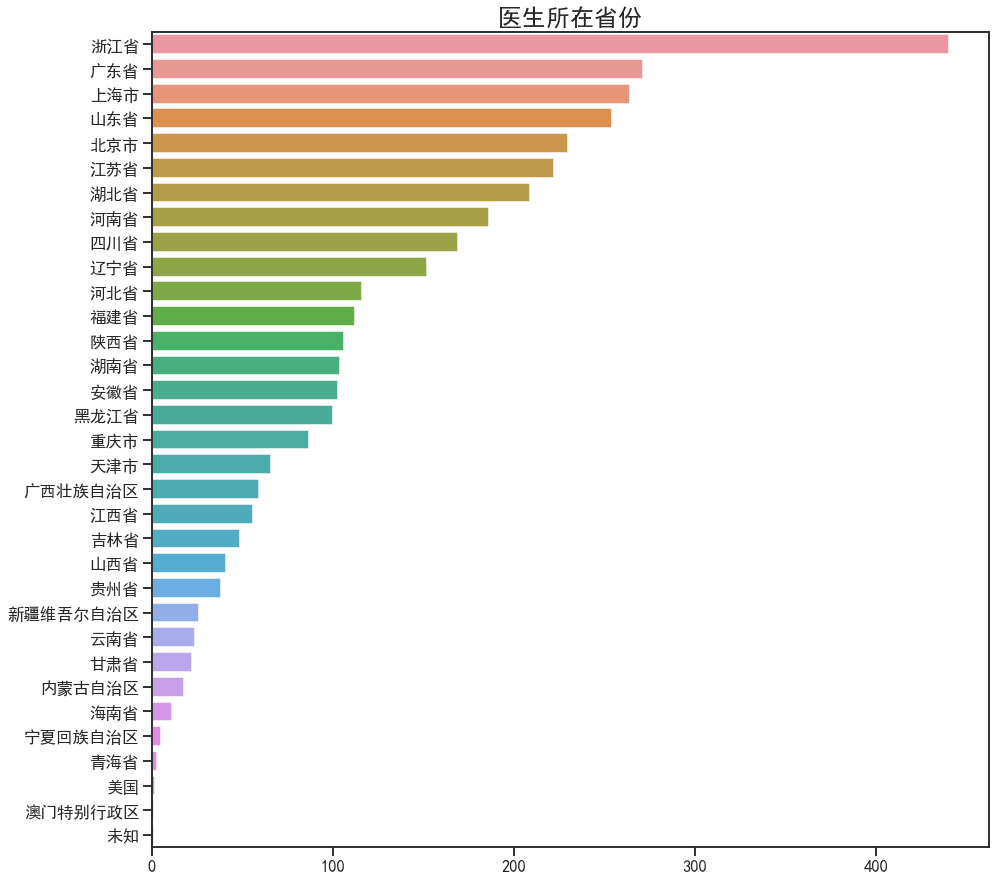

In [17]:
fig = plt.figure(figsize=(15, 15))
ax = sns.countplot(y = 'province', data=doctors, order = doctors['province'].value_counts().index)
ax.set_xlabel(None)
ax.set_ylabel(None)
plt.title('医生所在省份', fontsize=24)
plt.savefig('analysis/doctors_province.jpg')

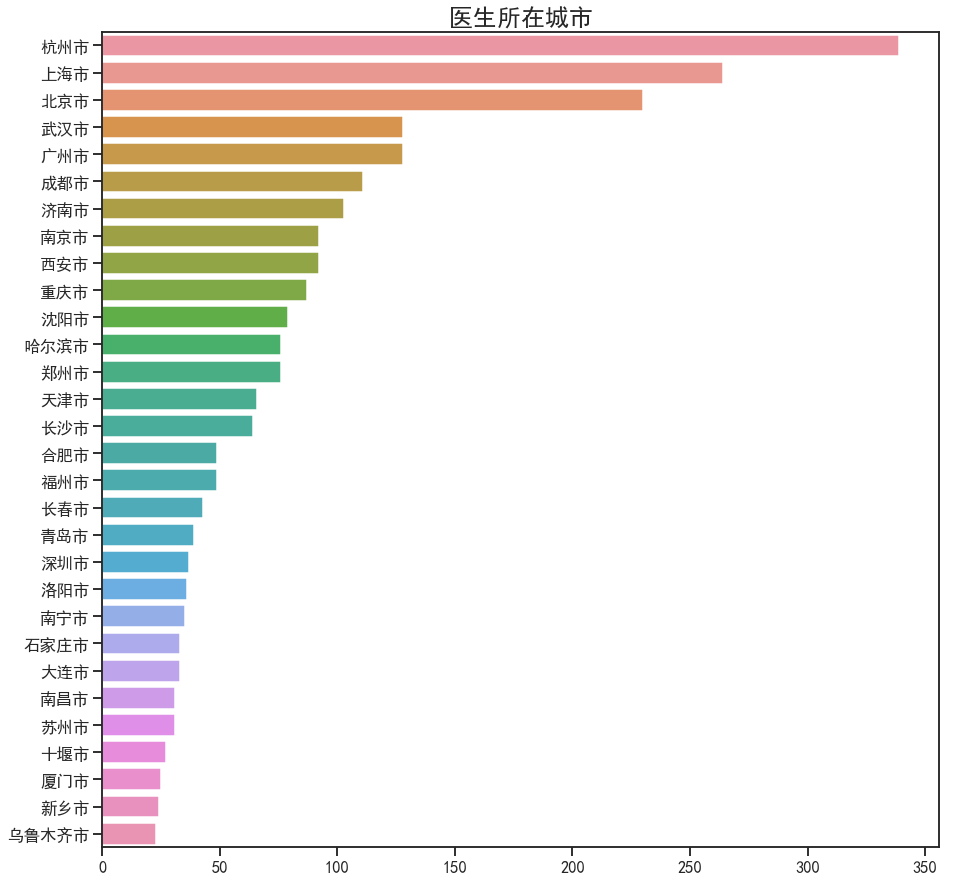

In [18]:
ncity = doctors.loc[doctors['city'].isin(doctors['city'].value_counts().index[:30]), :]
fig = plt.figure(figsize=(15, 15))
ax = sns.countplot(y = 'city', data=ncity, order = ncity['city'].value_counts().index)
# ax.set_yticklabels(ax.get_yticklabels(),fontsize=16)
# ax.set_xticklabels(ax.get_xticks().astype(int),fontsize=16)
ax.set_xlabel(None)
ax.set_ylabel(None)
plt.title('医生所在城市', fontsize=24)
plt.savefig('analysis/doctors_cities.jpg')

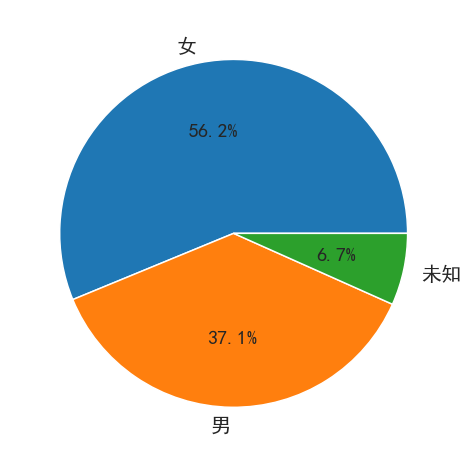

In [19]:
gender = doctors['gender'].map({0:'男', 1:'女', -1:'未知'})
ngender = gender.value_counts()
plt.figure(figsize=(8,8))
plt.pie(ngender.values, labels=ngender.index, autopct='%1.1f%%', textprops={'fontsize': 20})
plt.savefig('analysis/doctors_gender.jpg')

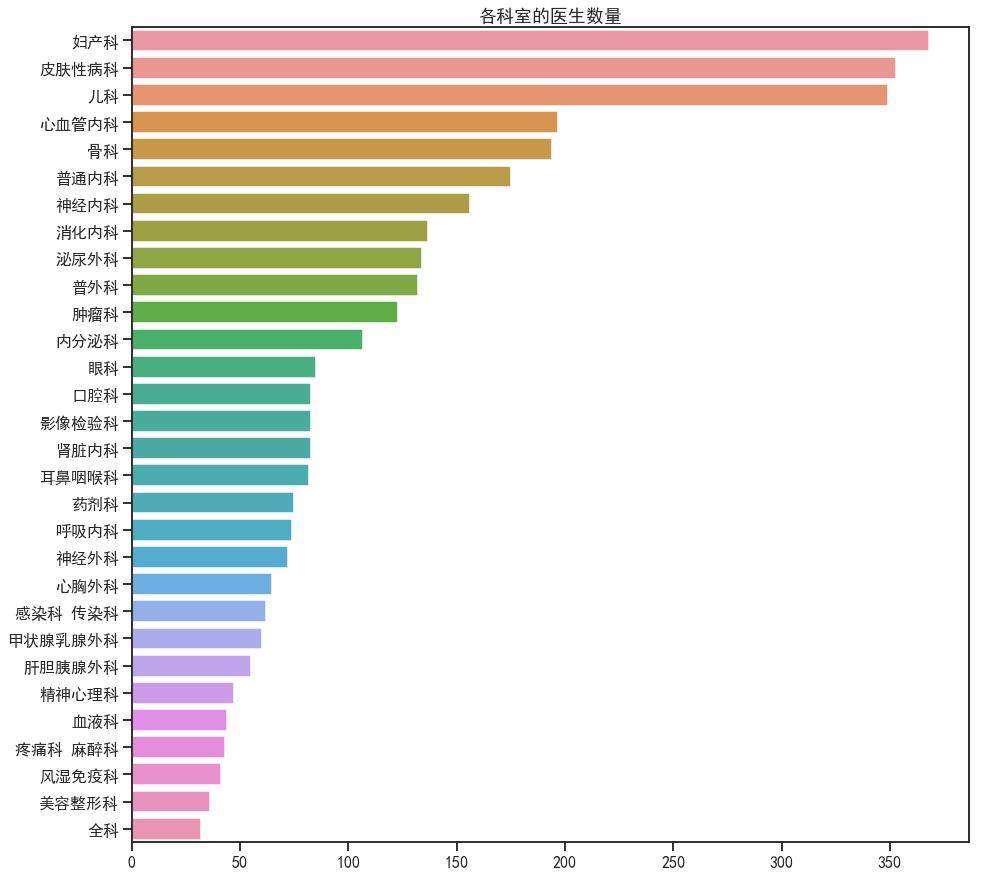

In [21]:
fig = plt.figure(figsize=(15,15))
ax = sns.countplot(y='section_group', data=doctors, order=doctors['section_group'].value_counts().index)
ax.set_xticklabels(ax.get_xticks().astype(int), fontsize=16)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)
ax.set_xlabel(None)
ax.set_ylabel(None)
plt.title('各科室的医生数量')
plt.savefig('analysis/doctors_sections.jpg')

dialogs_iter = pd.read_sql('select * from dialogs_unique;', dx_con, chunksize=1000)

from pkuseg import pkuseg
from tqdm import tqdm
seg = pkuseg(model_name='medicine')
tqdm.pandas(desc='dialogs progress')


def chunk_preprocess(chunk, segger):
    processed_df = chunk.copy()
    processed_df['date'] = pd.to_datetime(processed_df['date'])
    
    columns_to_seg = chunk.columns.drop(['index','id', 'date', 'doctor_id'])
    processed_df[columns_to_seg] = chunk[columns_to_seg].applymap(segger.cut)
    return processed_df


for count, dialogs in tqdm(enumerate(dialogs_iter)):
    chunk_preprocess(dialogs, seg).to_pickle('chunk-{}.pickle'.format(count))


In [22]:
import glob
dialogs_seg = None
chunk_file_iter = glob.iglob('chunk-*.pickle')
dialogs_seg = pd.concat([pd.read_pickle(f) for f in chunk_file_iter])

In [23]:
dialogs_seg = dialogs_seg.join(doctors.set_index('id')[ 'section_group'], on='doctor_id')
dialogs_seg.head()

,index,id,date,doctor_id,question,answer,q1,a1,q2,a2,section_group
0,0,2081697,2018-05-17 01:46:01,11,"[28, 周岁, ，, 男, ，, 症状, ：, 双手, 经常, 控制, 不住, 颤抖, ，...","[问题, 收到, 了, ，, 我, 在, 出, 差路, 上, ，, 到, 酒店, 后, 回复...","[1., 我, 这几天, 手, 不怎么, 抖, 拍, 不, 出来, 2., 记忆力, 减退,...","[谢谢, 补充, 信息, 。, 你, 这个, 年纪, 的, 双手, 抖动, ，, 有, 几,...","[谢谢, 。, 我, 改天, 去, 查, 一, 查, 。, 因为, 我, 每年, 都, 体检...","[大部分, 体检, 是, 不, 会, 包含, 甲状腺, 功能, 以及, 甲状腺, B超, 的...",神经内科
1,1,1799371,2018-05-12 09:47:29,11,"[性别, 女, ，, 30岁, 。, 最近, 一, 周, 脸颊, 部分, 发凉, ，, 有,...","[麻烦, 上传, 一下, 做, 微笑, 表情, 的, 面部, 自拍, 照片, 。, 另外, ...","[两侧, 发凉, ，, 左侧, ，, 也, 就是, 嘴角, 抽动, 的, 那一侧, ，, 凉...","[感谢, 补充, 信息, 。, 面瘫, 一般, 表现, 为, 一侧, （, 也, 有, 双侧...","[哦, ，, 我, 有, 喝, 咖啡, 的, 习惯, 。, 还有, 我, 4.27, 日, ...","[这个, 和, HPV, 疫苗, 注射, 没有, 什么, 关系, 。, 主动, 的, 方法,...",神经内科
2,4,1929013,2018-04-13 08:44:29,11,"[张, 医生, ，, 您, 好, ：, 我, 今年, 45, 岁, ，, 女性, ，, 被,...",[],"[去年, 七八月份, ，, 再次, 发作, ，, 不知, 是否, 跟, 进入, 更年期, 有...",[],"[这样, 过, 了, 两, 天, ，, 我, 的, 感觉, 是, ：, 只要, 我, 在, ...","[谢谢, 你, 的, 提问, ，, 这个, 平台, 每个, 问题, 只, 允许, 追问, 两...",神经内科
3,5,1922609,2018-05-16 23:07:24,11,"[张老板, 您, 好, ，, 我, 上次, 提问, 之后, ，, 让, 我, 母亲, 做, ...","[问题, 收到, 了, ，, 我, 在, 出, 差路, 上, ，, 到, 酒店, 后, 回复...","[非常, 感谢, 您, 的, 耐心, 回答, ，, 我, 先, 让, 我, 母亲, 尝试, ...","[对, 的, ，, 这个, 阶段, ，, 她, 自己, 有, 意识, 的, 调整, 会, 起...",[],[],神经内科
4,6,2068451,2018-04-01 19:33:35,11,"[带状疱疹, ，, 第二, 天, ，, 皮肤痛, 的, 厉害, 怎么办, ？]","[疼痛, 急性期, ，, 可以, 先, 试试芬, 必得, 看看, ，, 芬必得, 无效, 的...",[],[],[],[],神经内科


dialogs = pd.read_sql('select * from dialogs_unique;', dx_con)    
dialogs.head()

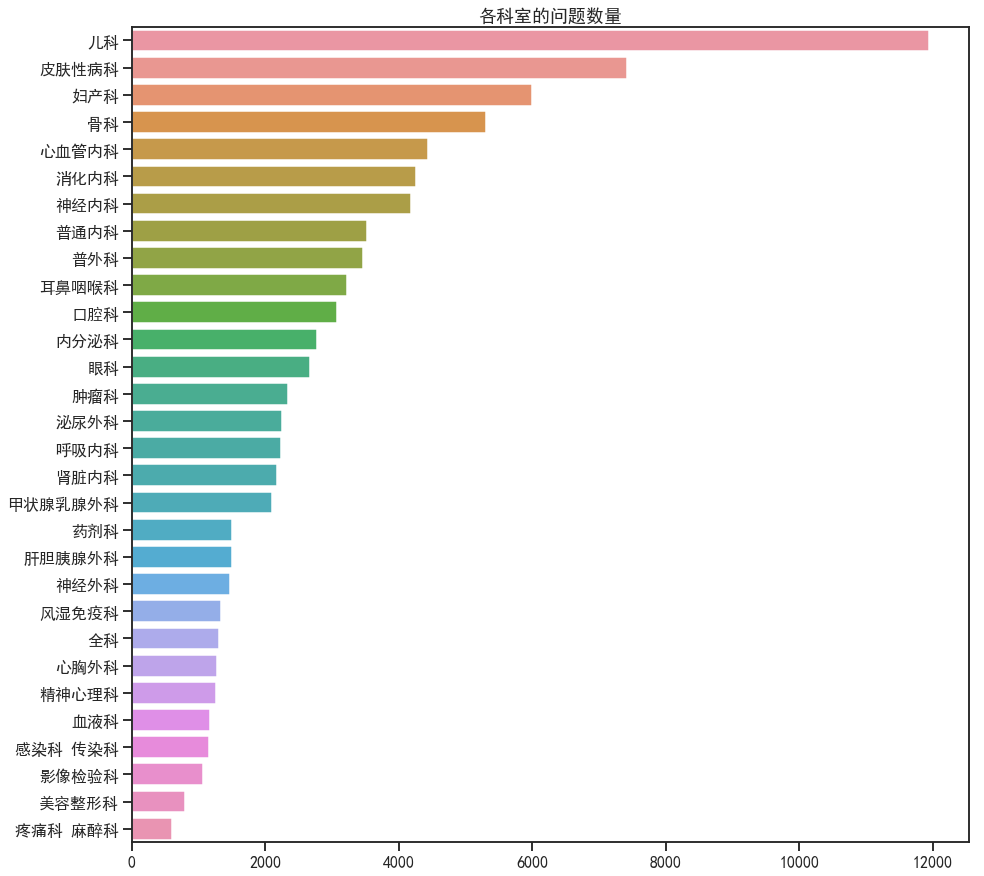

In [28]:
fig = plt.figure(figsize=(15,15))
ax = sns.countplot(y='section_group', data=dialogs_seg, order=dialogs_seg['section_group'].value_counts().index)
plt.title('各科室的问题数量')
ax.set_xticklabels(ax.get_xticks().astype(int), fontsize=16)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)
ax.set_xlabel(None)
ax.set_ylabel(None)
plt.savefig('analysis/dialogs_sections.jpg')

In [22]:
import re
def find_age(row):
    q = row['question'] + row['q1'] + row['q2']
    age = re.search('今年([0-9]{1,2})|([0-9]{1,2})岁', q)
    if not age:
        age = re.search('([0-9]{1,2})周岁', q)
    if age:
        age = age.group(1)
    else:
        age = -1
    return age


dialogs['age'] = dialogs.apply(find_age, axis=1)


In [23]:
def find_gender(row):
    q = row['question'] + row['q1'] + row['q2']
    gender = -1
    male_list = ['男', '儿子', '父亲', '爸爸', '爷爷', '叔叔']
    female_list = ['女', '女儿', '母亲', '妈妈', '奶奶', '姨妈', '她', '怀孕', '生孩子', '生完孩子']
    if re.search('|'.join(male_list), q):
        gender = 1
    elif re.search('|'.join(female_list), q):
        gender = 0
    return gender
dialogs['gender'] = dialogs.apply(find_gender, axis=1)


In [24]:
dialogs = dialogs.join(doctors.set_index('id')['section_group_id'], on='doctor_id')

In [43]:
doctors.groupby('province')['section_group']

In [50]:
def find_overlap_gender(row):
    q = row['question'] + row['q1'] + row['q2']
    male_list = ['男', '儿子', '父亲', '爸爸', '爷爷', '叔叔']
    female_list = ['女', '女儿', '母亲', '妈妈', '奶奶', '姨妈', '她', '怀孕', '生孩子', '生完孩子']
    if re.search('|'.join(male_list), q) and re.search('|'.join(female_list), q):
        return True
    else:
        return False
overlap = dialogs.apply(find_overlap_gender, axis=1)
overlap.value_counts()

False    85466
True      2362
dtype: int64

In [52]:
dialogs[overlap==True]

,index,id,date,doctor_id,question,answer,q1,a1,q2,a2,age,gender,section_group_id
0,0,2081697,2018-05-17 01:46:01,11,28周岁，男，症状：双手经常控制不住颤抖，如果没睡好，第二天手会一直微抖。情绪激动时，手发麻...,问题收到了，我在出差路上，到酒店后回复您。此条请勿回复。麻烦补充一些信息：1. 可否上传一段...,1.我这几天手不怎么抖 拍不出来2.记忆力减退就是刚想做个事情一会儿就给忘了，很频繁出现，以...,谢谢补充信息。你这个年纪的双手抖动，有几种可能性：1. 甲亢：甲状腺机能亢进会出现双手的抖动...,谢谢。我改天去查一查。因为我每年都体检 各项指标正常，体检包括甲状腺的检查吗？还有您提到甲亢...,大部分体检是不会包含甲状腺功能以及甲状腺B超的。如果你脖子比较粗，那么我建议你尽快去做检查，...,28,1,12
35,43,3111262,2018-10-07 10:44:14,11,您好！本人29岁，男性，左额头皮，在洗脸和刷牙时会有针扎似的疼痛，是怎么回事！谢谢！,,她们说是三叉神经痛，可以药物治疗吗？吃什么药？,问题收到，感谢提问，在给你具体建议之前，我还需要你补充一些信息。平台对每个问题只允许追问两次...,没感冒发烧，是医生，疼痛就几秒钟，只要洗脸刷牙，或者用手触摸左面部就会疼痛，,恩，谢谢补充信息，不过我的第一个问题你没有回复我。1. 出现疼痛的症状总共已经多久时间了？根...,29,1,12
48,62,2422949,2018-10-03 15:10:07,11,请问植物神经紊乱有什么好的治疗方法？两年心脏不舒服，检查显示没有问题。老怀疑自己有病。断断续...,感谢提问。请问，检查显示没有问题，但是你还是非常担心，你担心什么事情呢？是担心有大问题没有查...,我的原因比较特殊，但也不妨跟您坦白讲。真正担心的原因有两条：）1.自己真的“发病”没有人在身...,谢谢你补充信息。才几分钟时间，你就写了这么多字，写的非常有条理，清晰，排版也很干净，比我强很...,谢谢医生，我明白了。我会尝试做让自己恐惧的事情，也把自己的心绪写成故事，慢慢和解。另外，关于...,丁香医生平台有一个专门讲焦虑的课程，其中的案例就是讲那些总是担心自己心脏有问题的情况，建议你...,16,1,12
60,80,3381879,2018-11-06 07:19:56,11,您好医生，本人女，36岁，目前在坦桑尼亚工作生活。6年前曾患带状疱疹并经历过那种非人的疼痛折...,感谢提问，你的描述我仔细看过了，写的很详细清晰，非常感谢。带状疱疹一般都是局限在某一条神经的...,谢谢医生，我自己觉得也不是特别焦虑啊😜 孩子也基本康复了今天出院。没有感冒，发烧等其他症状。...,谢谢补充。从的描述来看，疼痛是特别明显的，而且会痛醒，那么一般来说，这种疼痛就是器质性的病变...,我们这里的军医有这两种药，阿昔洛韦片为0.1g的，吃几片呢？,阿昔洛韦，成人常用量一次0.8g，一日5次，因为一天要吃5吃，吃起来有点麻烦。甲钴胺片，一次...,36,1,12
86,115,3384479,2019-04-15 13:14:04,261,26岁，无性生活过，去年10月份体检检查出了一个子宫肌瘤和少量盆腔积液，没有吃任何药，今年1...,先说结论：这个医生不行，下次换个医生，或者换家医院。没有过性生活，就不要担心盆腔炎的问题。正...,医生，这种盆腔积液是不是每次去b超检查基本都会有！我半年内做了3次b超检查，每次都有盆腔积液...,因为盆腔积液本来就是正常的，所以每次都看到也是正常的，并没有什么趋势，就是正常波动。这个报告...,,,26,1,5
93,124,2962248,2019-03-28 16:45:39,261,医生您好~31岁，女，身高168，体重136斤。先生30岁，体型稍胖。双方三代中根据了解无已...,确实没必要做羊穿。nt检查只要是在11周-13周+6天做就可以了，头臀高的检查只是为了核实孕...,您好，我们这里的医院有普通无创还有plus版本，我应该做哪个比较合适？谢谢~,没必要plus，只要基本的无创就足够了，本来也没啥大问题。,,,31,1,5
109,151,2997262,2019-01-25 15:58:32,261,田医生，您好，我今年32岁，第一胎男孩顺产，第二胎8周多胎停做了清宫手术，现在第三次怀孕14...,B超现实胎盘覆盖宫颈内口，少量阴道流血应该是和这个胎盘位置有关。不过，这个孕周的胎盘低置，和...,怀孕前做过检查，没有妇科方面的疾病，1月16号做了检查，也没有阴道炎这些炎症。1月10号做B...,是的，应该考虑和胎盘位置有关。中孕期阴道流血，主要就是需要排除胎盘问题和宫颈问题，现在既然有...,田医生，太感谢您了，医生说宫内感染的话这孩子要不了了，真是吓死人,没事，别怕。宫内感染不是有个血常规就能诊断的。没有发热、腹痛这样的症状，就不会考虑宫内感染，...,32,1,5
111,153,2655479,2018-11-24 14:54:27,261,26岁，女生，两三年前做TCT、HPV筛查，结果正常，17年7月生了孩子，今年11月初再次做...,你没病，先把心放到肚子里，再往下看。TCT+HPV两个阴性，本来可以5年再复查的。现在既然已...,哈哈，感谢田医生回复。这次提问好值得！一次回复到位。不知道还问啥，就随便问问吧。多囊卵巢综合...,调节月经可以是用优思明，或者月经后半期用黄体酮，只要能基本预测下次月经什么时候来，也就可以了...,,,26,1,5
301,412,1663060,2018-01-05 00:03:54,925563,男 27岁，备孕体检，发现弱精子症，畸形率高症状（结果见图片），不满足怀孕标准。 1.医生让...,您好！1. 少弱精症，药物治疗的效果一般不太好。我们医院很少进行药物治疗，这两种药我们不常用...,少弱精症很少用药物治疗的话，你一般是使用使用何种方式？关于补充维生素，我买了非处方药 善存佳...,严重少弱精症伴有不孕不育者，药物治疗效果一般不好，我们多建议直接试管婴儿治疗。可以用善存，这...,,,27,1,5
348,484,2505657,2018-09-09 09:39:39,268,您好，我的宝宝七个半月，她的大拇脚趾两个月以前有点红肿，最近因为会爬了要经常大拇脚趾用劲，红...,您好，晚复见谅，回复如下：1.宝宝的趾甲的确有甲旁组织红肿，这多半是摩擦导致的，建议给宝宝足...,谢谢您的详细解答，因为给宝宝修指甲的工具都是粗头的，而且我也试着修了，结痂地方的指甲已经嵌入...,您好，晚复见谅，一般还是建议您到医院去找骨科医生或者皮肤科医生，具体可以问导医，问问嵌甲在哪...,,,-1,1,40


In [5]:
for col in dialogs_seg.columns[4:]:
    dialogs_seg[col] = dialogs_seg[col].str.join(' ')

In [19]:
def read_wordlist(file):
    return [line.rstrip('\n') for line in open(file, encoding='utf-8')]

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = pd.concat([dialogs_seg['answer'], dialogs_seg['a1'], dialogs_seg['a2']], axis=0)
vectorizer = TfidfVectorizer(token_pattern='\\b\\w+\\b', stop_words=read_wordlist('stopwords.txt'), use_idf=True)
vectors = vectorizer.fit_transform(corpus)

                        

C:\Users\William\Anaconda3\envs\MedicAnalysis\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['若果'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [47]:
weights = np.ravel(vectors.mean(axis=0))
words = vectorizer.get_feature_names()
weights = pd.Series(data=weights, index=words)

In [48]:
weights.sort_values(ascending=False)[:50]

没有    0.021912
会     0.018790
治疗    0.017881
需要    0.017163
情况    0.015451
建议    0.015131
检查    0.014505
可能    0.013721
吃     0.013712
问题    0.013536
症状    0.013231
做     0.012947
药物    0.012764
次     0.012068
宝宝    0.011710
目前    0.011017
医院    0.010408
考虑    0.010061
感染    0.009937
一下    0.009792
孩子    0.009600
手术    0.009416
注意    0.009262
天     0.009116
感谢    0.009024
比较    0.008982
不要    0.008682
正常    0.008598
你好    0.008458
出现    0.008425
信任    0.008382
时间    0.008230
请     0.008111
引起    0.008095
是否    0.007774
祝     0.007643
使用    0.007641
一个    0.007617
客气    0.007609
口服    0.007575
影响    0.007411
现在    0.007119
这种    0.007104
疼痛    0.007060
服用    0.006867
饮食    0.006837
太     0.006827
两     0.006818
先     0.006652
复查    0.006648
dtype: float64

In [40]:
co = ['这是 一个 测试 的 文本',
     '这是 另一个 测试 用途 的 文本',
     '这 又是 一个 新的 测试 用途 的 文本',
     '这是 第四行 的 文字 用来 看看 新的 词汇']
tfidfv = TfidfVectorizer(token_pattern='\\b\\w+\\b', use_idf = False, norm=None)
print(tfidfv.fit_transform(co))

  (0, 4)	1.0
  (0, 9)	1.0
  (0, 6)	1.0
  (0, 0)	1.0
  (0, 14)	1.0
  (1, 8)	1.0
  (1, 2)	1.0
  (1, 4)	1.0
  (1, 9)	1.0
  (1, 6)	1.0
  (1, 14)	1.0
  (2, 5)	1.0
  (2, 1)	1.0
  (2, 13)	1.0
  (2, 8)	1.0
  (2, 4)	1.0
  (2, 9)	1.0
  (2, 6)	1.0
  (2, 0)	1.0
  (3, 12)	1.0
  (3, 10)	1.0
  (3, 7)	1.0
  (3, 3)	1.0
  (3, 11)	1.0
  (3, 5)	1.0
  (3, 9)	1.0
  (3, 14)	1.0


In [41]:
print(tfidfv.get_feature_names())

['一个', '又是', '另一个', '文字', '文本', '新的', '测试', '用来', '用途', '的', '看看', '第四行', '词汇', '这', '这是']
